# Recommendations with IBM
## 5. Singular Value Decomoposition
This notebook is the fifth one in the Recommendations with IBM project. In this notebook I created a recommendation function based on user similarities. Different from collaborative filtering, in this notebook I am going to use matrix fatorization i.e. singular value decomposition.For this purpose:
1. Create a user-item matrix. 
2. Perform SVD with entire data set (this is for explanotary purpose)
3. Perfom SVD with test and train data sets to evaluate the model


I used IBM data set for this project. The detailed infromation regarding the data sets can be found in the first notebook: Exploratory Analysis.   
If you need to make a recommendation to a new user, you can use rank based recommendation explained in the second notebook in this repo.
You can also find and example of collaborative filtering in this repo.

In [12]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#read the data
df = pd.read_csv('user-item-interactions.csv')
del df['Unnamed: 0']

#to make data look better we converted the emails to user ids.
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()


,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### 1. Creating user-item matrix

In [13]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df_grouped=df.groupby(['user_id','article_id']).count() #create a groupby object
    df_grouped.loc[df_grouped['title']>1]=1 #changes the numbers higher than 1 to 1
    user_item=df_grouped.unstack() #placec users to rows and articles to columns
    user_item=user_item.fillna(0) #fills NaN values as 0s

    
    
    
    return user_item # return the user_item matrix 

In [14]:
user_item_matrix = create_user_item_matrix(df)
user_item_matrix.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                   ...                                                   \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1             0.0  ...    0.0    0.0    1.0    0.0    1.0    0.0    0.0   
2             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0  ...    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
4             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1             0.0    0.0    0.0  
2             0.0    0.0    0.0  
3             0.0    0.0    0.0  
4             0.0    0.0    0.0  
5             0.0    0.0    0.0  

[5 rows x 714 columns]

### 2. Performing SVD with entire data
SVD can be easily performed by linalg.svd method in numpy.

In [15]:
# Perform SVD on the User-Item Matrix
u, s, vt =  np.linalg.svd(user_item_matrix, full_matrices=True)

In [16]:
print( s.shape,u.shape,vt.shape)

(714,) (5149, 5149) (714, 714)


In [17]:
s[0:5]

array([55.34570373, 23.2486418 , 21.76002282, 20.65833406, 19.97088674])

The s matrix is a diagonal matrix includes factor weights. In this case we have 714 factors as we have 714 articles in the data sets. This is the maximum number of factors.

In [18]:
u[0:5]

array([[-4.30899801e-02, -8.30671762e-03, -2.75704572e-02, ...,
         8.01765481e-04,  6.59280069e-04,  7.14951337e-05],
       [-1.03765691e-02, -1.64771768e-02, -6.04781444e-03, ...,
         9.72520168e-04,  5.73728929e-04, -1.24118928e-03],
       [-4.98474594e-02, -1.44789670e-03,  1.64960631e-02, ...,
         1.65007034e-03,  9.38243374e-04, -1.91470417e-03],
       [-4.25553357e-02, -3.94068256e-02,  3.67445597e-02, ...,
        -1.59572624e-04, -3.95514410e-03,  5.51341821e-04],
       [-6.72606012e-03, -4.04544053e-03, -5.98956086e-04, ...,
        -4.99241958e-04,  9.35771066e-04, -7.28217510e-04]])

u matrix shows user preferences on each factor. It is 5149 x 5149 as we have 5149 rows in our user item matrix. In this case we can not use all 5149 columns here as we have at most 714 factors. Later we will select a subset of this matrix

In [19]:
vt[0:5]

array([[-0.00221822, -0.02604036, -0.00246327, ..., -0.00050441,
        -0.00492688, -0.00404343],
       [-0.00207737,  0.0281658 , -0.00051368, ..., -0.00262161,
        -0.01325774, -0.01327298],
       [ 0.00043211, -0.0135172 , -0.00300468, ..., -0.00157638,
        -0.01481189, -0.00798957],
       [-0.00332539,  0.02634998, -0.00263887, ..., -0.00284663,
        -0.01926753, -0.00453883],
       [ 0.00425736,  0.01385477, -0.00256688, ...,  0.00018271,
        -0.00244594, -0.00217779]])

vt matix shows factor weights of each article. It is a transpose matrix i.e. rows represent factors and columns represents articles. As you see it is 714 by 714 matrix. 

#### Deciding number of factors

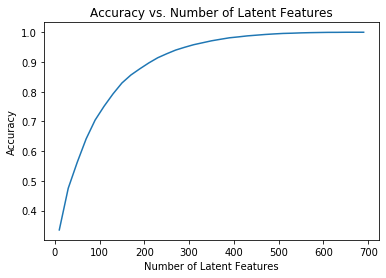

In [20]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

As you can see the graph above, while the number of factors increases the accuracy increases. 

### 3. Dividing Data to Test and Train 

In [21]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train=create_user_item_matrix(df_train)
    user_item_test=create_user_item_matrix(df_test)
    test_idx=list(user_item_test.index)
    test_arts=list(user_item_test.columns)
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [22]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True)

In [23]:
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


In [27]:
#lets take a look at how many articles and users are common in test and train data
train_ind = user_item_train.index[user_item_train.index.isin(test_idx)]
test_ind = user_item_test.index.isin(train_ind)
test_ind = user_item_test.index[test_ind]

u_test = u_train[user_item_train.index.isin(test_idx), :]
len(u_test)

20

This means that we can only make predictions about 20 users in the test data as there are only 20 common users.

In [28]:
#lets do the same thing for vt
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
len(vt_test)

714

this means we can make predictions about all articles.

In [42]:
#lets take a look at how our svd works on training data
num_latent_feats = np.arange(10,700+10,20)
train_sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    train_sum_errs.append(err)

In [29]:
#lets take a look at how our svd works on test data
num_latent_feats = np.arange(10,700+10,20)
test_sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new = np.diag(s_train[:k])
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_test_new, s_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test.loc[train_ind], user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    test_sum_errs.append(err)

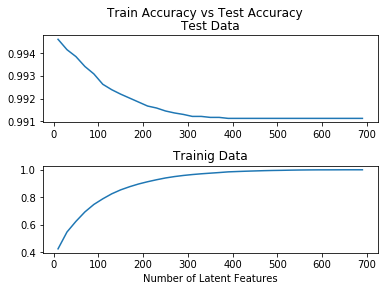

In [43]:
fig, axs = plt.subplots(2)
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('Train Accuracy vs Test Accuracy')
axs[0].plot(num_latent_feats, 1 - np.array(test_sum_errs)/df.shape[0])
axs[1].plot(num_latent_feats, 1 - np.array(train_sum_errs)/df.shape[0])

axs[1].set_title('Trainig Data')
axs[0].set_title('Test Data')

plt.xlabel('Number of Latent Features');

In matrix factorization example here, we observe that the accuracy decreasing in test data as number of factors increases while in training data it actually incerases as the numner of factors increse. This may be an indicatior of over fitting. In this example we only have 20 common users in train and test data. In the future, different test and train data sets can be used to test the accuracy.